## 1. Przygotowanie notebooka

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
import kagglegym

env = kagglegym.make() # Stworzenie Środowiska
observation = env.reset() # Otrzymanie pierwszej próbki danych
train = observation.train # Otrzymanie ramki danych z pierwszej próbki

%matplotlib inline

### 2. Wstępny opis danych

In [2]:
print('Ilość wierszy: {}, Ilość kolumn: {}'.format(*train.shape))
cols = [0, 0, 0]
for c in train.columns:
    if 'derived' in c: cols[0] += 1
    if 'fundamental' in c: cols[1] += 1
    if 'technical' in c: cols[2] += 1
print('kolumny derived: {}, kolumny fundamental: {}, kolumny technical: {}'
    .format(*cols))
print('Ilość unikalnych znaków czasowych: {}'.format(train["timestamp"].unique().size))
cols = [col for col in train.columns if col not in ['id','timestamp','y']]
nulls = train[cols].isnull().sum()
print('Wszystkie puste wartości: {0}, każda kolumna ma średnio {1:.0f} pustych wartości'
    .format(nulls.sum(), nulls.mean()))

Number of rows: 806298, Number of columns: 111
Derived columns: 5, Fundamental columns: 63, Technical columns: 40
Number of unique timestamps: 906
all null values: 12282356, every column has an average 113726 null values


### 3. Wypełnienie luk średnimi

In [2]:
mean_values = train.mean(axis=0)
train.fillna(mean_values, inplace=True)

### 4. Regresja liniowa

In [4]:
cols_to_use = [col for col in train.columns if col not in ['id','timestamp','y']]

model = lm.LinearRegression()
model.fit(np.array(train[cols_to_use]), train.y.values)

while True:
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[cols_to_use])
    observation.target.y = model.predict(test_x)
    target = observation.target
    
    observation, reward, done, info = env.step(target)
    if done:
        break
        
info

{'public_score': -0.0056828420938354702}

### 5. Histogram y

Max y value in train :  0.0934978
Min y value in train :  -0.0860941


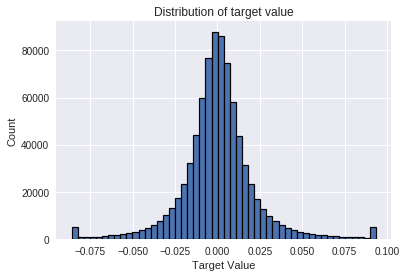

In [5]:
y = train.y.values
plt.hist(y, bins=50, edgecolor='black', linewidth=1.2)
plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('Distribution of target value')
print('Max y value in train : ',train.y.max())
print('Min y value in train : ',train.y.min())

### 6. Odfiltrowanie próbek dla skrajnych y

In [6]:
high_y_cut = 0.093497
low_y_cut = -0.086093

y_is_above_cut = (train.y > high_y_cut)
y_is_below_cut = (train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
y_is_within_cut.value_counts()

True     796880
False      9418
Name: y, dtype: int64

### 7. Regresja liniowa z filtrowaniem skajnych y

In [7]:
# Wczytanie danych od nowa
env = kagglegym.make()
observation = env.reset()
train = observation.train
mean_values = train.mean(axis=0)
train.fillna(mean_values, inplace=True)

In [8]:
model = lm.LinearRegression()
model.fit(np.array(train.loc[y_is_within_cut, cols_to_use].values), train.loc[y_is_within_cut, 'y'])

while True:
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[cols_to_use])
    observation.target.y = model.predict(test_x).clip(low_y_cut, high_y_cut)
    target = observation.target
    
    observation, reward, done, info = env.step(target)
    if done:
        break
        
info

{'public_score': -0.003614189933349948}

### 8. Pca pojeście pierwsze

In [9]:
from pca import pca
env = kagglegym.make()
observation = env.reset()
train = observation.train
mean_values = train.mean(axis=0)
train = train.fillna(mean_values, inplace=True)

In [10]:
train_x, y, evals, evecs = pca(np.array(train[cols_to_use]), red_cmps_to=10)
model = lm.LinearRegression()
model.fit(train_x[y_is_within_cut], train.loc[y_is_within_cut, 'y'])

while True:
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[cols_to_use])
    test_x_pca = np.dot(np.transpose(evecs), np.transpose(test_x))
    test_x_pca = np.transpose(test_x_pca)
    observation.target.y = model.predict(test_x_pca).clip(low_y_cut, high_y_cut)
    target = observation.target
    
    observation, reward, done, info = env.step(target)
    if done:
        break
        
info

{'public_score': -0.0034090373427553338}

### 9. Korelacja kolumn do wyniku

In [5]:
env = kagglegym.make()
observation = env.reset()
train = observation.train
mean_values = train.mean(axis=0)
train.fillna(mean_values, inplace=True)

In [6]:
corrcoefs = []
for col in cols_to_use:
    corrcoefs.append([col, np.corrcoef(train[col].values, train.y.values)[0, 1]])
corrcoefs = np.array(corrcoefs)

corrcoefs_vals = corrcoefs[:,1].astype(np.float)
corrcoefs_abs = np.absolute(corrcoefs_vals)
sort_indices = corrcoefs_abs.argsort()
sorted_corrcoefs = np.flip(corrcoefs[sort_indices], axis=0)
top_corrcoefs = sorted_corrcoefs[:20]
print('Max correlation coefficient: ', np.absolute(top_corrcoefs[:,1].astype(np.float)).max())
print('Min correlation coefficient: ', np.absolute(top_corrcoefs[:,1].astype(np.float)).min())
top_corrcoefs

Max correlation coefficient:  0.0161537610929
Min correlation coefficient:  0.00359671956071


array([['technical_30', '0.0161537610929'],
       ['technical_20', '-0.0156396653507'],
       ['fundamental_11', '0.0108379372595'],
       ['fundamental_51', '0.00798150013626'],
       ['fundamental_53', '0.0078433356271'],
       ['technical_19', '-0.00777823068846'],
       ['technical_40', '-0.00690638846324'],
       ['technical_7', '-0.00674199165259'],
       ['technical_11', '-0.00545567759903'],
       ['technical_2', '-0.00486273325449'],
       ['fundamental_13', '0.00466957279298'],
       ['technical_17', '-0.00461245563077'],
       ['fundamental_56', '0.00453583924232'],
       ['technical_6', '-0.00449208757575'],
       ['technical_43', '-0.00439436623504'],
       ['technical_21', '-0.00434309735651'],
       ['fundamental_23', '-0.00422781875112'],
       ['fundamental_55', '0.00403718923065'],
       ['fundamental_50', '-0.00383381664646'],
       ['technical_36', '-0.00359671956071']], 
      dtype='<U18')

In [17]:
cols_to_use = top_corrcoefs[:,0]
train_x, y, evals, evecs = pca(np.array(train[cols_to_use]), red_cmps_to=5)
model = lm.LinearRegression()
model.fit(train_x[y_is_within_cut], train.loc[y_is_within_cut, 'y'])

while True:
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[cols_to_use])
    test_x_pca = np.dot(np.transpose(evecs), np.transpose(test_x))
    test_x_pca = np.transpose(test_x_pca)
    observation.target.y = model.predict(test_x_pca).clip(low_y_cut, high_y_cut)
    target = observation.target
    
    observation, reward, done, info = env.step(target)
    if done:
        break
        
info

{'public_score': 0.0047396490596362919}